In [1]:
import math
import numpy as np
import wandb
import pickle
import os
import shapely.wkt as wkt
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from torch_geometric.transforms import LineGraph

import gzip
import xml.etree.ElementTree as ET

import torch
import torch_geometric
from torch_geometric.data import Data

import processing_io as pio
import sys
import os
import joblib
import json

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from shapely.geometry import Point, LineString, box
from matplotlib.colors import TwoSlopeNorm

from shapely.ops import unary_union
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch_geometric.data import Data, Batch
import torch
from torch_geometric.data import Data
import alphashape
from matplotlib.lines import Line2D

from shapely.geometry import Polygon
from torch.utils.data import DataLoader, Dataset, Subset


districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")

# Add the 'scripts' directory to the Python path
scripts_path = os.path.abspath(os.path.join('..'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

import gnn_io as gio
import gnn_architectures as garch
import help_functions as hf

import copy

def replace_invalid_values(tensor):
    tensor[tensor != tensor] = 0  # replace NaNs with 0
    tensor[tensor == float('inf')] = 0  # replace inf with 0
    tensor[tensor == float('-inf')] = 0  # replace -inf with 0
    return tensor

def normalize_data_given_scaler(dataset_input, x_scalar_list = None, pos_scalar=None, y_scalar=None, normalize_y=False, normalize_pos=False):
    dataset = normalize_x_values_given_scaler(dataset_input, x_scalar_list)
    if normalize_pos:
        dataset = normalize_positional_features_given_scaler(dataset, pos_scalar)
    if normalize_y:
        dataset = normalize_y_values_given_scaler(dataset, y_scalar)
    return dataset

def normalize_x_values_given_scaler(dataset, x_scaler_list):
    for i in range(4):
        scaler = x_scaler_list[i]
        data_x_dim = replace_invalid_values(dataset.x[:, i].reshape(-1, 1))
        normalized_x_dim = torch.tensor(scaler.transform(data_x_dim.numpy()), dtype=torch.float)
        dataset.x[:, i]=  normalized_x_dim.squeeze()
    return dataset

def normalize_positional_features_given_scaler(dataset, pos_scalar=None):
    for data in dataset:
        data.pos = torch.tensor(pos_scalar.transform(data.pos.numpy()), dtype=torch.float)
    return dataset

def normalize_y_values_given_scaler(dataset, y_scalar=None):
    for data in dataset:
        data.y = torch.tensor(y_scalar.transform(data.y.numpy()), dtype=torch.float)
    return dataset

In [2]:
# Parameters to define
run_path = '/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/data/runs_y_normalized_robust_scaler/hidden_64_hidden_layer_str_[64]_/'
model_path = run_path +  'trained_model/model.pth'
data_created_during_training = run_path + 'data_created_during_training/'
indices_of_datasets_to_use = [0, 1, 3, 4]

scaler_x = joblib.load(data_created_during_training + 'x_scaler.pkl')
scaler_y = joblib.load(data_created_during_training + 'y_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'pos_scaler.pkl')

In [3]:
# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)
correct_test_dataset= test_set_loader.dataset[0]

In [4]:
test_data = "../../data/test_data/gdf_pop_1pm_policy_in_1_2_3_4.geojson"
test_data = gpd.read_file(test_data)
base_case = "../../data/test_data/gdf_basecase_mean_pop_1pm.geojson"
base_case = gpd.read_file(base_case)

In [15]:
test_data.head()

,link,from_node,to_node,length,freespeed,capacity,lanes,modes,vol_car,storageCapacityUsedInQsim,highway,geometry,from_idx,to_idx
0,100315,24972409,24972408,16.181257,8.333333,480.0,1.0,"bus,car,car_passenger",6.9,NaN,residential,"LINESTRING (2.33869 48.85181, 2.33847 48.85181)",0,8
1,100316,5904976363,24983651,14.860209,8.333333,480.0,1.0,"bus,car,car_passenger,pt",7.9,NaN,tertiary,"LINESTRING (2.33874 48.85242, 2.33872 48.85229)",1,2
2,100317,24983651,5904976363,14.860209,8.333333,960.0,2.0,"bus,car,car_passenger,pt",1.2,NaN,tertiary,"LINESTRING (2.33872 48.85229, 2.33874 48.85242)",2,1
3,100321,664205947,24972376,22.264540,8.333333,960.0,2.0,"car,car_passenger",6.1,NaN,residential,"LINESTRING (2.33994 48.85200, 2.33986 48.85181)",3,4
4,100324,24972376,24972375,64.853276,8.333333,480.0,1.0,"bus,car,car_passenger",7.1,NaN,residential,"LINESTRING (2.33986 48.85181, 2.33909 48.85152)",4,11


In [5]:
test_input_linegraph = pio.create_test_data_object(base_case=base_case, test_data = test_data) # check this function if there have been changes in the features of the data
test_data_list = [test_input_linegraph] # we do it for just one test data object, for now.
dataset_only_relevant_dimensions = gio.cut_dimensions(dataset=test_data_list, indices_of_dimensions_to_keep=indices_of_datasets_to_use)
test_subset = Subset(dataset_only_relevant_dimensions[0], 0)

In [6]:
test_subset.dataset.x[:10]

tensor([[  7.0741, 480.0000,   0.0000,   4.0000],
        [  9.1481, 480.0000,   0.0000,   3.0000],
        [  2.0000, 960.0000,   0.0000,   3.0000],
        [  7.1852, 960.0000,   0.0000,   4.0000],
        [  8.1111, 480.0000,   0.0000,   4.0000],
        [  5.4444, 480.0000,   0.0000,   4.0000],
        [  5.4444, 480.0000,   0.0000,   4.0000],
        [  0.0000, 240.0000,   0.0000,   5.0000],
        [ 17.1111, 480.0000,   0.0000,   3.0000],
        [  6.7037, 480.0000,   0.0000,   4.0000]])

In [7]:
dataset_normalized = normalize_data_given_scaler(dataset_input=test_subset.dataset, x_scalar_list=scaler_x, pos_scalar=scaler_pos)

In [8]:
dataset_normalized.x[:10]

tensor([[ 0.0795, -0.5715,  0.3782,  0.5976],
        [ 0.2217, -0.5715,  0.3782,  0.1290],
        [-0.2682, -0.3785,  0.3782,  0.1290],
        [ 0.0871, -0.3785,  0.3782,  0.5976],
        [ 0.1506, -0.5715,  0.3782,  0.5976],
        [-0.0321, -0.5715,  0.3782,  0.5976],
        [-0.0321, -0.5715,  0.3782,  0.5976],
        [-0.4052, -0.6681,  0.3782,  1.0662],
        [ 0.7673, -0.5715,  0.3782,  0.1290],
        [ 0.0541, -0.5715,  0.3782,  0.5976]])

In [9]:
test_dl = gio.create_dataloader(dataset=dataset_normalized, is_train=False, batch_size=16, train_ratio=0, is_test=True)

Total dataset length: 5


In [10]:
in_channels = 6  # Example value
out_channels = 1  # Example value
hidden_layers_base_for_point_net_conv = 64
hidden_layer_structure = [64]  # Example value

# Initialize the model
model = garch.MyGnn(in_channels=in_channels, out_channels=out_channels, hidden_layers_base_for_point_net_conv=hidden_layers_base_for_point_net_conv, hidden_layer_structure=hidden_layer_structure)

# Load the model state dictionary
model.load_state_dict(torch.load(model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


Initializing PointNetConv(local_nn=Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
), global_nn=Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
))
Initializing 0.weight with kaiming_normal
Initializing 0.bias with zeros
Initializing 2.weight with kaiming_normal
Initializing 2.bias with zeros
Initializing 0.weight with kaiming_normal
Initializing 0.bias with zeros
Initializing 2.weight with kaiming_normal
Initializing 2.bias with zeros
Initializing 4.weight with kaiming_normal
Initializing 4.bias with zeros
Initializing Linear(in_features=6, out_features=64, bias=True)
Initializing Linear(in_features=64, out_features=64, bias=True)
Initializing Linear(in_features=64, out_features=32, bias=True)
Initializing Linear(in_features=32, 

In [11]:
loss_fct = torch.nn.MSELoss()
test_loss, r_squared, actual_vals, predictions = hf.validate_one_model(model, dataset_normalized, loss_fct, device)
print(f'Test Loss: {test_loss}')
print(f'r_squared: {r_squared}')
print(f'actual_vals shape: {len(actual_vals)}')
print(f'predictions shape: {len(predictions)}')

Test Loss: 1.0381120443344116
r_squared: -0.9289973974227905
actual_vals shape: 31216
predictions shape: 31216


In [14]:
test_data

,link,from_node,to_node,length,freespeed,capacity,lanes,modes,vol_car,storageCapacityUsedInQsim,highway,geometry,from_idx,to_idx
0,100315,24972409,24972408,16.181257,8.333333,480.0,1.0,"bus,car,car_passenger",6.9,NaN,residential,"LINESTRING (2.33869 48.85181, 2.33847 48.85181)",0,8
1,100316,5904976363,24983651,14.860209,8.333333,480.0,1.0,"bus,car,car_passenger,pt",7.9,NaN,tertiary,"LINESTRING (2.33874 48.85242, 2.33872 48.85229)",1,2
2,100317,24983651,5904976363,14.860209,8.333333,960.0,2.0,"bus,car,car_passenger,pt",1.2,NaN,tertiary,"LINESTRING (2.33872 48.85229, 2.33874 48.85242)",2,1
3,100321,664205947,24972376,22.264540,8.333333,960.0,2.0,"car,car_passenger",6.1,NaN,residential,"LINESTRING (2.33994 48.85200, 2.33986 48.85181)",3,4
4,100324,24972376,24972375,64.853276,8.333333,480.0,1.0,"bus,car,car_passenger",7.1,NaN,residential,"LINESTRING (2.33986 48.85181, 2.33909 48.85152)",4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31211,pt_IDFM:480531,pt_IDFM:480531,pt_IDFM:480531,20.000000,20.000000,7999.2,1.0,"artificial,stopFacilityLink,subway",0.0,NaN,None,"LINESTRING (2.31340 48.89433, 2.31340 48.89433)",18119,18119
31212,pt_IDFM:480541,pt_IDFM:480541,pt_IDFM:480541,20.000000,20.000000,7999.2,1.0,"artificial,stopFacilityLink,subway",0.0,NaN,None,"LINESTRING (2.31343 48.89429, 2.31343 48.89429)",18120,18120
31213,pt_IDFM:480541_pt_IDFM:480286,pt_IDFM:480541,pt_IDFM:480286,699.892849,12.000000,7999.2,1.0,"artificial,subway",0.0,0.777581,None,"LINESTRING (2.31343 48.89429, 2.31519 48.88810)",18120,18117
31214,pt_IDFM:480964,pt_IDFM:480964,pt_IDFM:480964,20.000000,20.000000,7999.2,1.0,"artificial,stopFacilityLink,tram",0.0,NaN,None,"LINESTRING (2.27117 48.83802, 2.27117 48.83802)",18121,18121


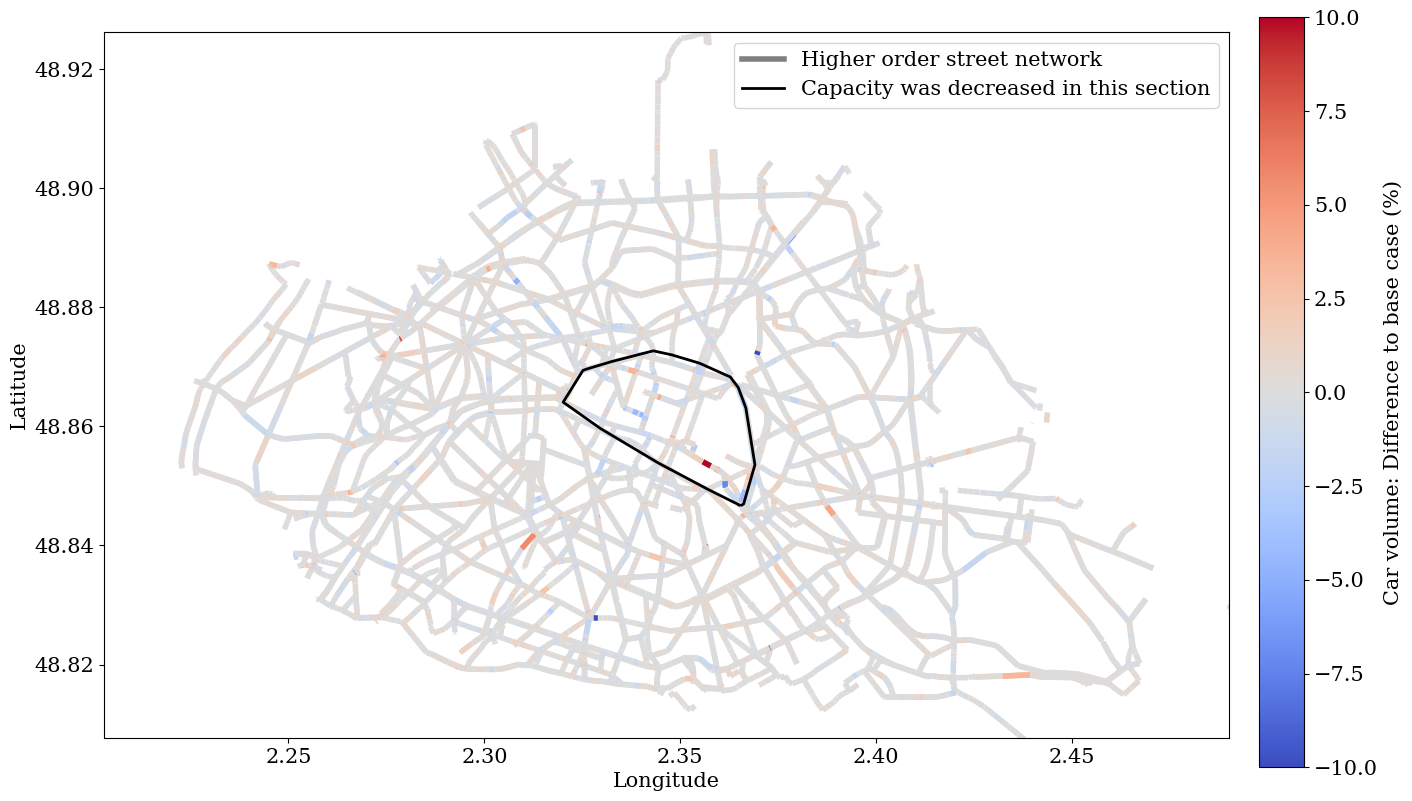

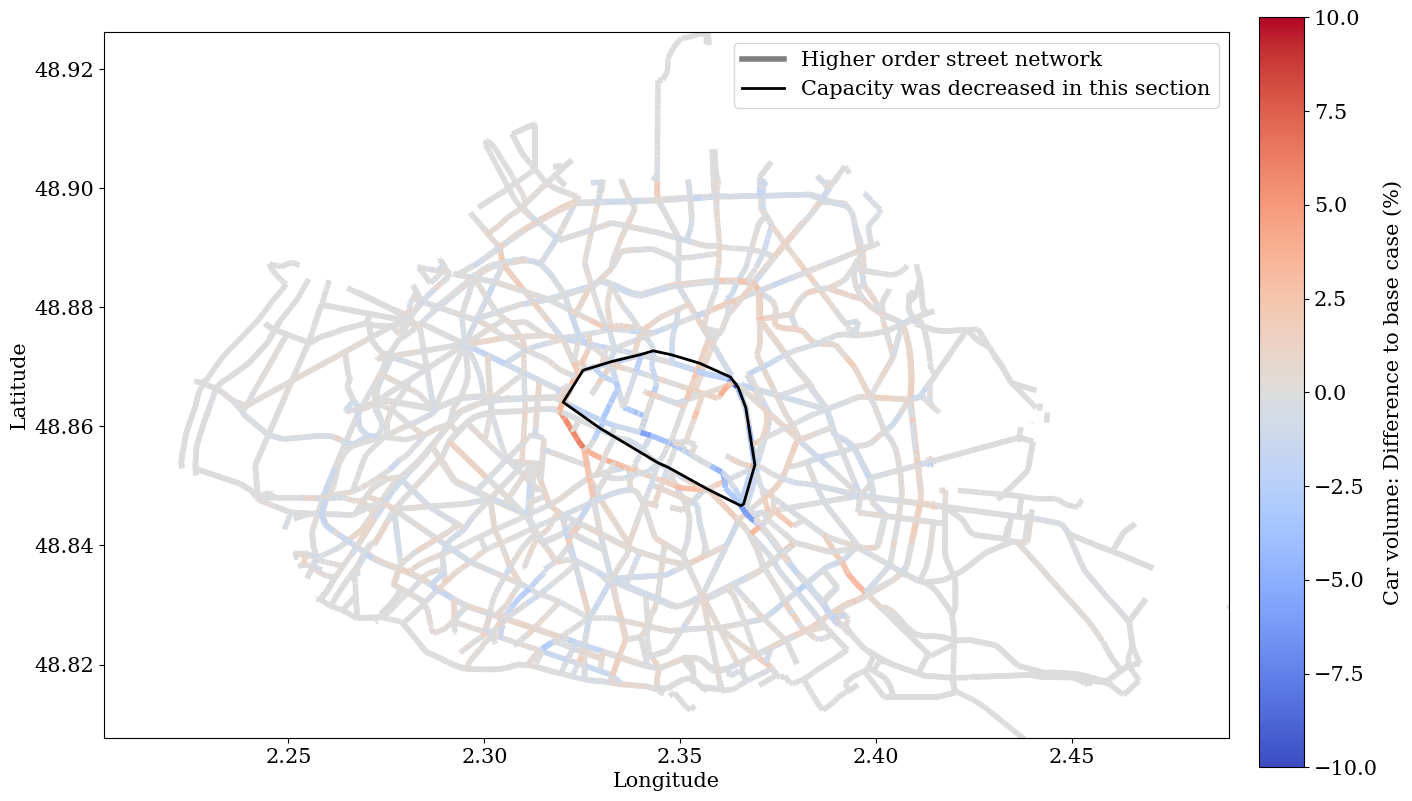

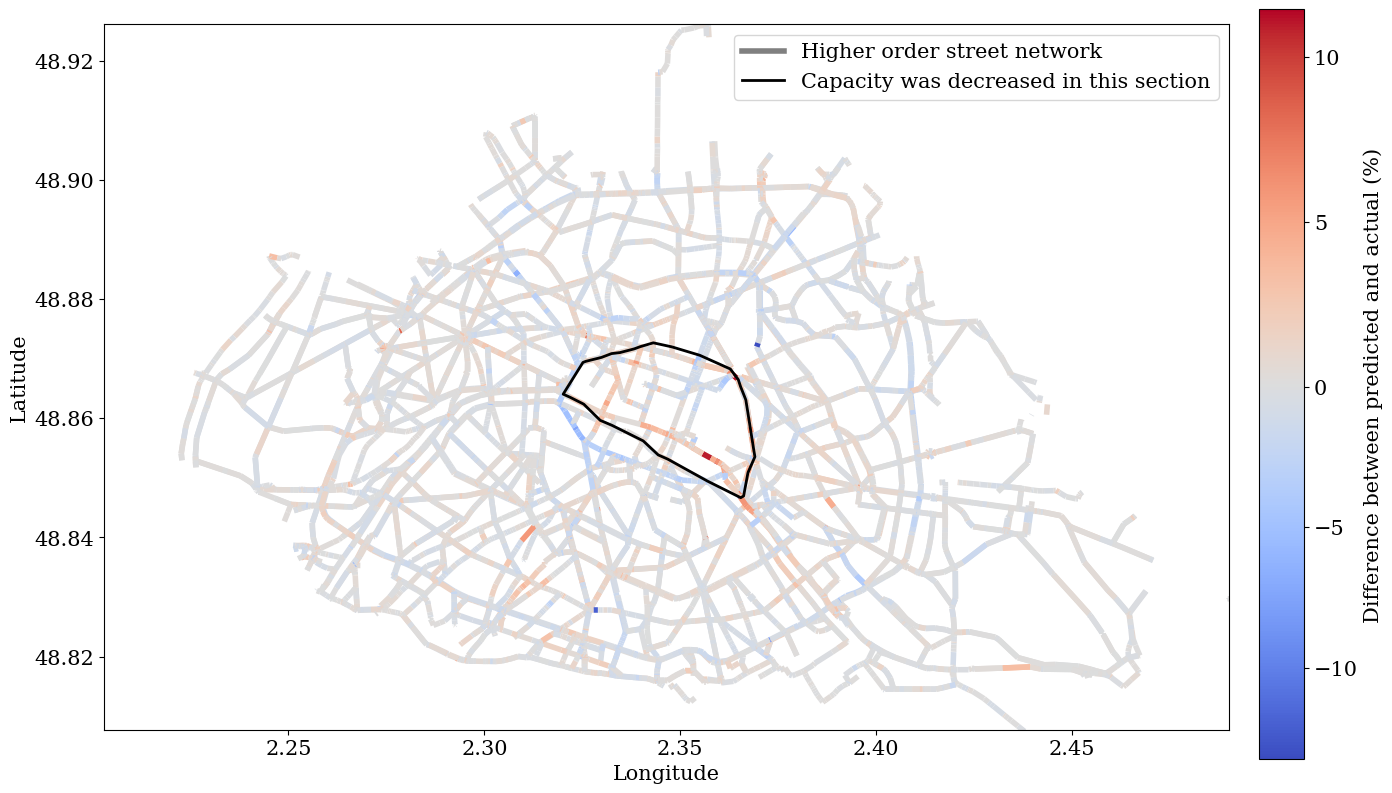

In [12]:
i= 0
gdf = hf.data_to_geodataframe(data=test_dl.dataset, original_gdf=test_data, predicted_values=predictions)
gdf_with_og_values = hf.map_to_original_values(input_gdf=gdf, scaler_x =scaler_x, scaler_y=scaler_y)
hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="og_vol_car_change_predicted", save_it=False, number_to_plot=1, is_predicted=True, alpha=0)
hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="og_vol_car_change_actual", save_it=False, number_to_plot=1, is_predicted=False,alpha=10)
hf.plot_difference_output(gdf_input=gdf_with_og_values, column1="og_vol_car_change_predicted", column2="og_vol_car_change_actual", save_it=False, number_to_plot=1)